In [18]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn.model_selection import StratifiedShuffleSplit
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import warnings
warnings.filterwarnings('ignore')

import os
from sklearn.datasets import fetch_olivetti_faces
faces = fetch_olivetti_faces()

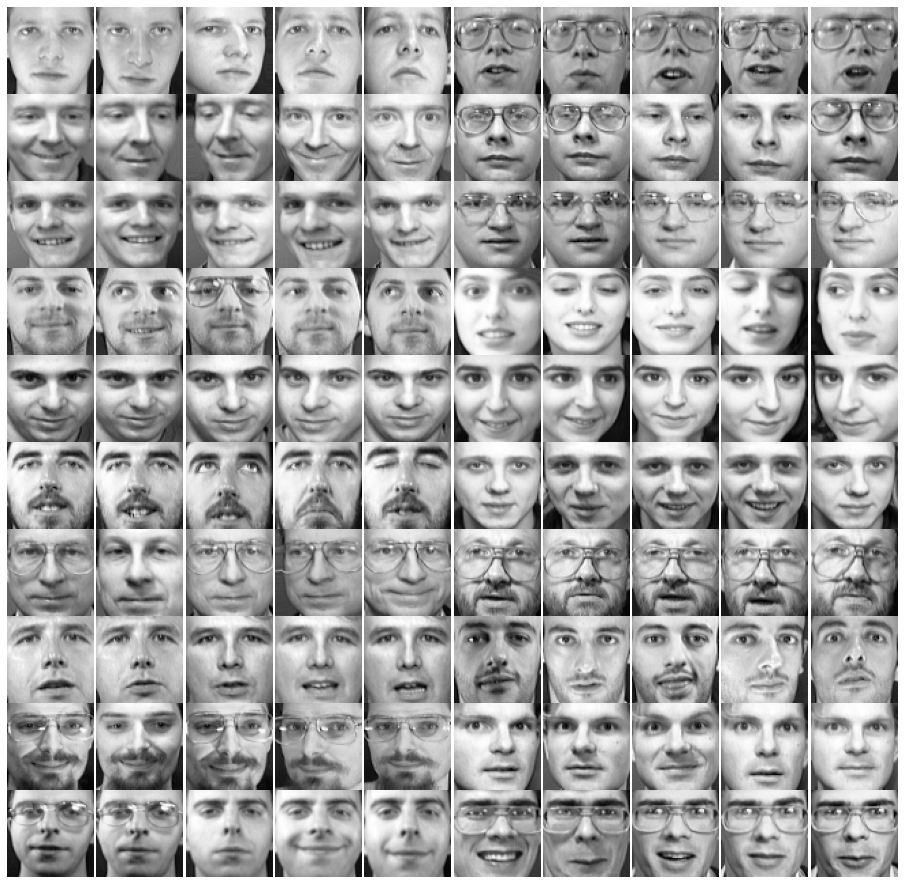

In [3]:
fig, axes = plt.subplots(10, 10, figsize=(16, 16))
fig.subplots_adjust(hspace=0, wspace=0)
for i, ax in enumerate(axes.flat):
    ax.imshow(ofaces.images[i*2], cmap='gray')
    ax.axis('off')

In [9]:
# inicio el metodo
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=40, random_state=42)
# obtengo los indices para el train_valid y el test. (¿porque usa el next?)
train_valid_idx, test_idx = next(strat_split.split(faces['images'], faces['target']))
# genero el train y test
X_train_valid = faces['images'][train_valid_idx]

y_train_valid = faces['target'][train_valid_idx]
X_test = faces['images'][test_idx]
y_test = faces['target'][test_idx]

# mismo procedimiento pero separo el train de la validacion
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=80, random_state=43)
train_idx, valid_idx = next(strat_split.split(X_train_valid, y_train_valid))
X_train = X_train_valid[train_idx]
y_train = y_train_valid[train_idx]
X_valid = X_train_valid[valid_idx]
y_valid = y_train_valid[valid_idx]

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to your first layer.


In [62]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',strides=(1,1), input_shape=(64, 64, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), strides=(1,1), activation='relu'))


Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically,  as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

### Add Dense layers on top

To complete the model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D,  then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs.

In [63]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(40))

In [64]:
# para ver la arquitectura del modelo
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 flatten_9 (Flatten)         (None, 53824)             0         
                                                                 
 dense_18 (Dense)            (None, 64)                3444800   
                                                                 
 dense_19 (Dense)            (None, 40)                2600      
                                                      

## Copilo y entreno el modelo

In [65]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=25, 
                    validation_data=(X_valid, y_valid))

Epoch 1/25
9/9 [==============================] - 2s 201ms/step - loss: 3.7881 - accuracy: 0.0393 - val_loss: 3.6651 - val_accuracy: 0.1375
Epoch 2/25
9/9 [==============================] - 2s 185ms/step - loss: 3.6412 - accuracy: 0.1179 - val_loss: 3.5772 - val_accuracy: 0.1125
Epoch 3/25
9/9 [==============================] - 3s 317ms/step - loss: 3.4940 - accuracy: 0.1536 - val_loss: 3.3673 - val_accuracy: 0.2875
Epoch 4/25
9/9 [==============================] - 2s 183ms/step - loss: 3.1635 - accuracy: 0.2893 - val_loss: 3.0172 - val_accuracy: 0.2625
Epoch 5/25
9/9 [==============================] - 2s 180ms/step - loss: 2.6315 - accuracy: 0.4036 - val_loss: 2.4475 - val_accuracy: 0.4000
Epoch 6/25
9/9 [==============================] - 2s 181ms/step - loss: 1.9982 - accuracy: 0.5607 - val_loss: 1.8891 - val_accuracy: 0.5375
Epoch 7/25
9/9 [==============================] - 2s 181ms/step - loss: 1.3548 - accuracy: 0.7036 - val_loss: 1.2978 - val_accuracy: 0.7000
Epoch 8/25
9/9 [====

3/3 - 0s - loss: 0.3307 - accuracy: 0.9375 - 120ms/epoch - 40ms/step


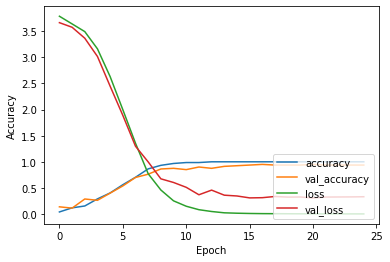

In [70]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_valid,  y_valid, verbose=2)

In [67]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

2/2 - 0s - loss: 0.4857 - accuracy: 0.8750 - 68ms/epoch - 34ms/step


In [69]:
history.history

{'loss': [3.78814435005188,
  3.641178846359253,
  3.493971586227417,
  3.1634521484375,
  2.631528377532959,
  1.9981802701950073,
  1.3548227548599243,
  0.7710224986076355,
  0.45954185724258423,
  0.251984179019928,
  0.14861969649791718,
  0.08233550190925598,
  0.04784350097179413,
  0.022785335779190063,
  0.015050575137138367,
  0.010133184492588043,
  0.007199910935014486,
  0.005955483764410019,
  0.004717665258795023,
  0.003855912247672677,
  0.003338513197377324,
  0.0028331640642136335,
  0.0022391604725271463,
  0.0019083167426288128,
  0.0015978923765942454],
 'accuracy': [0.03928571566939354,
  0.11785714328289032,
  0.15357142686843872,
  0.28928571939468384,
  0.4035714268684387,
  0.5607143044471741,
  0.7035714387893677,
  0.8642857074737549,
  0.9321428537368774,
  0.9678571224212646,
  0.9857142567634583,
  0.9857142567634583,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'val_loss': [3.665118455886841,
  3.577216386